<a href="https://colab.research.google.com/github/SeverinSchmidt/brax/blob/main/Custom_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training in Brax

In [Brax Environments](https://colab.research.google.com/github/google/brax/blob/main/notebooks/environments.ipynb) we learned about creating environments and using them to quickly generate rollouts. We can learn all kinds of fun and useful behaviors on those environments via Brax's built-in training algorithms.

Let's try them out!

In [1]:
#@title Install Brax and some helper modules
#@markdown ## ⚠️ PLEASE NOTE:
#@markdown This colab runs best using a TPU runtime.  From the Colab menu, choose Runtime > Change Runtime Type, then select **'TPU'** in the dropdown.

from datetime import datetime
import functools
import os

from IPython.display import HTML, clear_output


import matplotlib.pyplot as plt

# try:
#   import brax
# except ImportError:
!pip install git+https://github.com/SeverinSchmidt/brax.git@main
clear_output()
import brax

from brax import envs
from brax import jumpy as jp
from brax.io import html
from brax.io import model
from brax.training.agents.ppo import train as ppo
from brax.training.agents.sac import train as sac

import jax
import jax.numpy as jnp

import seaborn as sns


# if 'COLAB_TPU_ADDR' in os.environ:
#   from jax.tools import colab_tpu
#   colab_tpu.setup_tpu()

First let's pick an environment to train an agent.
If you want to preview/train 'humanoid_path', 'humanoid_lidar_staircase', 'humanoid_single_lidar_staircase', 'humanoid_staircase', 'humanoid_lidar_wall' or 'humanoid_flag'. Make sure to download their corresponding .stl file from the repository and upload the file to Colab. https://github.com/SeverinSchmidt/brax/tree/main/brax/envs/STLmodels


In [2]:
#@title Preview a Brax environment { run: "auto" }
#@markdown Select the environment to train:
env_name = "humanoid_path"  # @param ['ant', 'fetch', 'grasp', 'halfcheetah', 'hopper', 'humanoid', 'humanoidstandup', 'pusher', 'reacher', 'walker2d', 'grasp', 'ur5e', 'humanoid_wall', 'humanoid_path', 'humanoid_lidar_staircase', 'humanoid_single_lidar_staircase', 'humanoid_staircase', 'humanoid_lidar_wall', 'humanoid_flag']
env = envs.get_environment(env_name=env_name)
state = env.reset(rng=jp.random_prngkey(seed=0))

HTML(html.render(env.sys, [state.qp]))

# Training

Brax provides out of the box the following training algorithms:

* [Proximal policy optimization](https://github.com/google/brax/blob/main/brax/training/agents/ppo/train.py)
* [Soft actor-critic](https://github.com/google/brax/blob/main/brax/training/agents/sac/train.py)
* [Evolutionary strategy](https://github.com/google/brax/blob/main/brax/training/agents/es/train.py)
* [Analytic policy gradients](https://github.com/google/brax/blob/main/brax/training/agents/apg/train.py)
* [Augmented random search](https://github.com/google/brax/blob/main/brax/training/agents/ars/train.py)

Trainers take as input an environment function and some hyperparameters, and return an inference function to operate the environment.

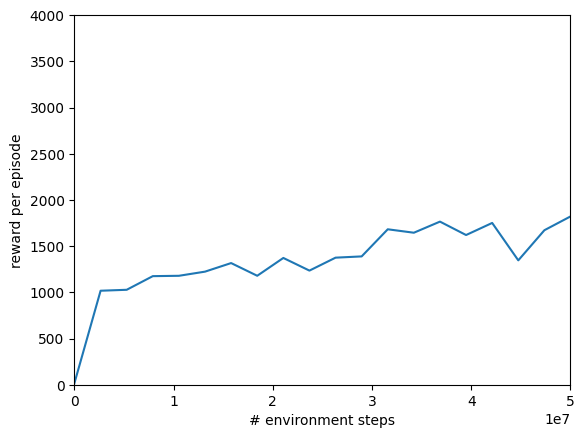

time to jit: 0:01:30.945866
time to train: 4:28:05.514555


In [3]:
#@title Training some pre-included Brax environments

#For training a task using the PPO algorithm
#Change the environment so that it fits with what was selected in the preview e.g. 'humanoid' or 'humanoid_staircase'
train_fn = {
  # OpenAI gym environments:
  'humanoid_path': functools.partial(ppo.train, num_timesteps=20000000, num_evals=20, reward_scaling=0.1, episode_length=1000, normalize_observations=True, action_repeat=1, unroll_length=10, num_minibatches=40, num_updates_per_batch=10, discounting=0.97, learning_rate=3e-4, entropy_cost=1e-3, num_envs=2048, batch_size=1024, seed=1),
}[env_name]

#This is for training the path task with the SAC algorithm. Uncomment the code below and comment out the above. 
# train_fn = {
#   # OpenAI gym environments:
#   'humanoid_path': functools.partial(sac.train, num_timesteps=50000000, num_evals=20, reward_scaling=1, episode_length=1000, normalize_observations=True, action_repeat=1, discounting=0.97, learning_rate=1e-4, num_envs=2048, batch_size=1024, grad_updates_per_step=64, max_devices_per_host=1, max_replay_size=1048576, min_replay_size=8192),
#   }[env_name]

max_y = {'ant': 8000, 'halfcheetah': 8000, 'hopper': 2500,'humanoid':4000,'humanoid_staircase': 4000, 'humanoid_path': 4000,'humanoid_wall': 4000,'humanoid_flag': 4000,'humanoid_lidar_staircase': 4000,'humanoid_single_lidar_staircase': 4000,'humanoid_lidar_wall': 4000 'humanoidstandup': 75_000, 'reacher': 5, 'walker2d': 5000, 'fetch': 15, 'grasp': 100, 'ur5e': 10, 'pusher': 0}[env_name]
min_y = {'reacher': -100, 'pusher': -150}.get(env_name, 0)

xdata, ydata = [], []
times = [datetime.now()]

def progress(num_steps, metrics):
  times.append(datetime.now())
  xdata.append(num_steps)
  ydata.append(metrics['eval/episode_reward'])
  clear_output(wait=True)
  plt.xlim([0, train_fn.keywords['num_timesteps']])
  plt.ylim([min_y, max_y])
  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.plot(xdata, ydata)
  plt.show()

make_inference_fn, params, metrics = train_fn(environment=env, progress_fn=progress)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


The trainers return an inference function, parameters, and the final set of metrics gathered during evaluation.

# Saving and Loading Policies

Brax can save and load trained policies:

In [4]:
model.save_params('/tmp/params', params)
params = model.load_params('/tmp/params')
inference_fn = make_inference_fn(params)


In [5]:
#If you wish to visualize a policy's behaviour using already learned params, then upload the params to Colab under 'tmp' and use the below lines of code
# params = model.load_params('/tmp/params')
# inference_fn = make_inference_fn(params)

# Visualizing a Policy's Behavior

We can use the policy to generate a rollout for visualization:

In [9]:
#@title Visualizing a trajectory of the learned inference function

# create an env with auto-reset
env = envs.create(env_name=env_name)
jit_env_reset = jax.jit(env.reset)
jit_env_step = jax.jit(env.step)
jit_inference_fn = jax.jit(inference_fn)

#for visualizing the reward
rewards = []
distance = []

rollout = []
rng = jax.random.PRNGKey(seed=3)
state = jit_env_reset(rng=rng)
for _ in range(1000):
  rollout.append(state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)
  rewards.append(state.reward.tolist())
  distance.append(state.metrics['distance_from_origin'].tolist())
  

HTML(html.render(env.sys, [s.qp for s in rollout]))

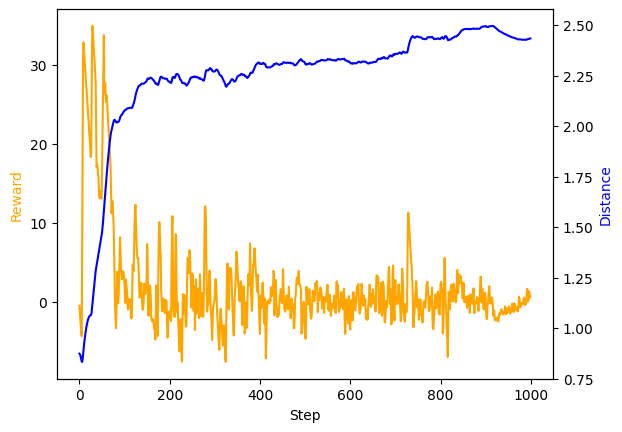

In [10]:
#Code for making the dual plot of reward and distance gained per timestep in an episode
# These lines generate the data to be plotted
x = [i for i in range(len(rewards))]
y = rewards
y1 = distance

fig, ax1 = plt.subplots() # initializes figure and plots

ax2 = ax1.twinx() # applies twinx to ax2, which is the second y axis. 

sns.lineplot(x = x, y = y, ax = ax1, color = 'orange') # plots the first set of data, and sets it to ax1. 
sns.lineplot(x = x, y = y1, color = 'blue', ax = ax2) # plots the second set, and sets to ax2. 

# these lines add the annotations for the plot. 
ax1.set_xlabel('Step')
ax1.set_ylabel('Reward', color='orange')
ax2.set_ylabel('Distance', color='blue')

plt.show(); # shows the plot. 

ವಿದಾಯ! 👋